## Processor tests

Here we run some basic tests. Make sure you have MountainLab installed on the computer running this jupyter lab.

In [1]:
#######################################
# imports and initialization
#######################################

# For development purposes, reload imported modules when source changes
%load_ext autoreload
%autoreload 2

# standard imports
import os, sys, json
import numpy as np
from matplotlib import pyplot as plt

# mountainlab imports
from mountainlab_pytools import mlproc as mlp
from mountainlab_pytools import mdaio

# Imports from this directory
dir0 = os.getcwd()
if dir0 not in sys.path:
    sys.path.append(dir0)
from view_timeseries import view_timeseries

In [2]:
#######################################
# Initialize the pipeline object
#######################################
Pipeline=mlp.initPipeline()

JSProxyWidget(status='Not yet rendered')

In [3]:
def test_mask_out_artifacts():
    
    # Create noisy array
    samplerate = int(48e3)
    duration = 30 # seconds
    n_samples = samplerate*duration
    noise_amplitude = 5
    noise = noise_amplitude*np.random.normal(0,1,n_samples)
    standard_dev = np.std(noise)
    
     # add three artefacts
    n_artifacts = 3
    artifacts = np.zeros_like(noise)
    artifact_duration = int(0.2*samplerate) # samples
    artifact_signal = np.zeros((n_artifacts, artifact_duration))

    for i in np.arange(n_artifacts):                   
        artifact_signal[i, :] = noise_amplitude*np.random.normal(0,6,artifact_duration)

    artifact_indices = np.tile(np.arange(artifact_duration), (3,1))

    artifact_shift = np.array([int(n_samples*0.10), int(n_samples*0.20), int(n_samples*0.70)])

    artifact_indices += artifact_shift.reshape((-1,1))

    for i, indices in enumerate(artifact_indices):
        artifacts[indices] = artifact_signal[i,:]

    signal = noise + artifacts

    timeseries = 'test_mask.mda'
    timeseries_out = 'masked.mda' 
    
    # write as mda
    mdaio.writemda32(signal.reshape((1,-1)), timeseries)
    
    # run the mask artefacts
    mlp.addProcess(
        'ephys.mask_out_artifacts',
        dict(
            timeseries=timeseries
        ),
        dict(
            timeseries_out=timeseries_out
        ),
        dict(
            chunk_size=2000,
            threshold=6,
            num_write_chunks=150,
        ),
        {}
    )
    mlp.runPipeline()

    
    # check that they are gone 
    read_data = mdaio.readmda(timeseries).reshape((-1,1))
    masked_data = mdaio.readmda(timeseries_out).reshape((-1,1))

    indices_masked = sum(masked_data[artifact_indices,0].flatten() == 0)
    total_indices_to_mask = len(artifact_indices.flatten())
    masked = indices_masked == total_indices_to_mask
    
    os.remove(timeseries)
    os.remove(timeseries_out)
    
    view_timeseries(read_data.T, trange=[0,read_data.shape[0]])
    view_timeseries(masked_data.T, trange=[0,masked_data.shape[0]])
    
    if masked:
        print('Artifacts 100% masked')
        return True
    else:
        print('Artifacts %.2f%% masked' % (100*(indices_masked/total_indices_to_mask)))
        return False

Output()

Finished pipeline.


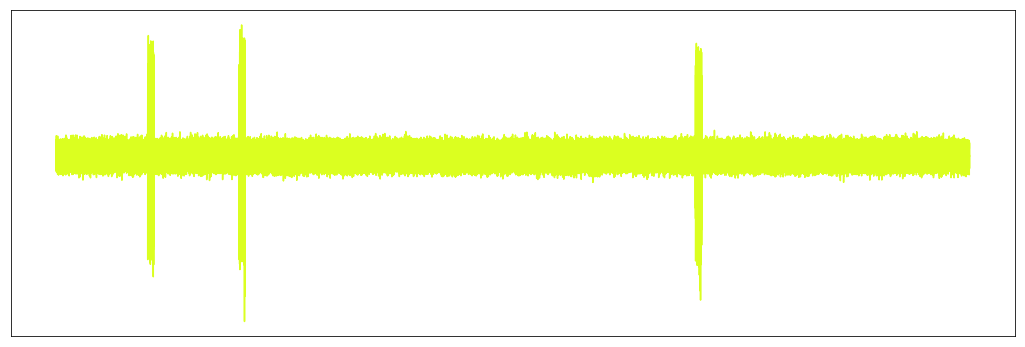

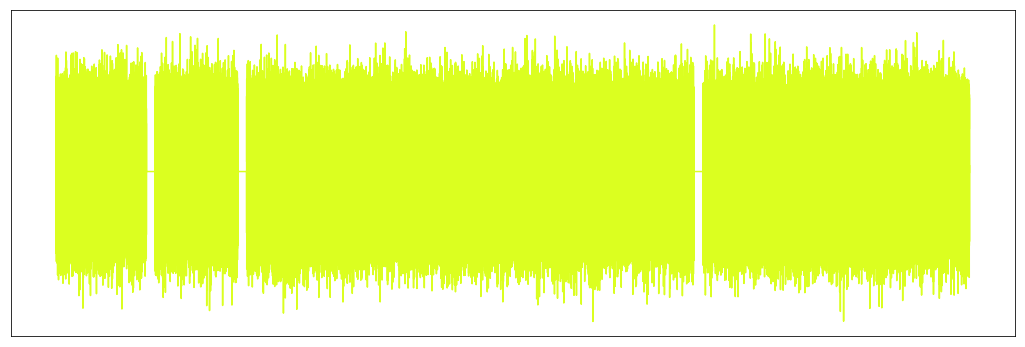

Artifacts 100% masked


Output()

Finished pipeline.


In [4]:
with Pipeline:
    test_mask_out_artifacts()